In [8]:
import os

import cv2
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
import h5py
import numpy as np
import pandas as pd
from skimage.util import view_as_windows

In [2]:
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [3]:
def generatePatches(X, step_size):
    X = X.reshape((1, 512, 512, 3))
    pe = image.PatchExtractor(patch_size=(step_size, step_size), max_patches=20)
    pe_fit = pe.fit(X)
    pe_trans = pe.transform(X)
    return pe_trans

In [4]:
def generatePatchesAsGrid(img, step_size=64):
    window_shape = (step_size, step_size, 3)
    B = view_as_windows(img, window_shape, step=step_size)
    B = B.reshape(64, 64, 64, 3)
    return B

In [5]:
def createPatches_bag_hdf5(save_path, img_name, img_patch):
    file_path = os.path.join(save_path, img_name) + '.h5'
    file = h5py.File(file_path, "w")
    dtype = img_patch.dtype
    # Initialize a resizable dataset to hold the output
    img_shape = img_patch.shape
    maxshape = (None,) + img_shape[1:] #maximum dimensions up to which dataset maybe resized (None means unlimited)
    dset = file.create_dataset('imgs', shape=img_shape, maxshape=maxshape, chunks=img_shape, dtype=dtype)
#     img_patch = np.array(img_patch)[np.newaxis,...]
    dset[:] = img_patch
    dset.attrs['patch_level'] = 0
    dset.attrs['wsi_name'] = img_name
    dset.attrs['downsample'] = 0
    dset.attrs['level_dim'] = 0
    dset.attrs['downsampled_level_dim'] = 0
    coord_dset = file.create_dataset('coords', shape=(20, 2), maxshape=(None, 2), chunks=(1, 2), dtype=np.int32)
    coord_dset[:] = (0,0)
    file.close()

In [10]:
source_path = 'tb_data/tb'
save_path = 'tb_patches'

In [11]:
for filename in os.listdir(source_path):
    img_name = filename.split('.')[0]
    source_img_path = os.path.join(source_path, img_name + '.png')
    img = load_image(source_img_path)
    patches = generatePatchesAsGrid(img)
    createPatches_bag_hdf5(save_path, img_name, patches)

In [69]:
filename = 'h0001.png'

In [70]:
img_name = filename.split('.')[0]
source_img_path = os.path.join(source_path, img_name + '.png')
img = load_image(source_img_path)
patches = generatePatchesAsGrid(img)
patches.shape

(64, 64, 64, 3)

In [60]:
img.shape

(512, 512, 3)

In [59]:
patches.shape

(20, 64, 64, 3)

In [19]:
img_special = patches[0]

In [21]:
from PIL import Image
img2 = Image.fromarray((img_special * 255).astype(np.uint8))


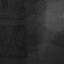

In [22]:
img2

In [49]:
data_folder = 'tb_data/'
categories = ['health', 'tb']
cases = []
labels = []
for category in categories:
    for file in os.listdir(data_folder + category):
        case = file.split('.')[0]
        cases.append(case)
        labels.append(category)

In [50]:
data_dict = {'case_id': cases, 'slide_id': cases, 'label': labels}
df = pd.DataFrame(data_dict)

In [51]:
df

,case_id,slide_id,label
0,h0001,h0001,health
1,h0003,h0003,health
2,h0004,h0004,health
3,h0005,h0005,health
4,h0006,h0006,health
...,...,...,...
4595,tb1192,tb1192,tb
4596,tb1194,tb1194,tb
4597,tb1196,tb1196,tb
4598,tb1197,tb1197,tb


In [52]:
df.to_csv('dataset_csv/label_information_tb.csv', index=False)

In [28]:
import torch
import torch.nn as nn
from models.model_clam import CLAM

In [29]:
instance_loss_fn = nn.CrossEntropyLoss()
model_dict = {"dropout": False, 'n_classes': 2, "size_arg": 'small'}
model = CLAM(**model_dict, instance_loss_fn=instance_loss_fn)
PATH = 'results/tb_v1_s1/s_0_checkpoint.pt'
model.load_state_dict(torch.load(PATH))
model.eval()

CLAM(
  (attention_net): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Attn_Net_Gated(
      (attention_a): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Tanh()
      )
      (attention_b): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): Sigmoid()
      )
      (attention_c): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (classifiers): ModuleList(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Linear(in_features=512, out_features=1, bias=True)
  )
  (instance_classifiers): ModuleList(
    (0): Linear(in_features=512, out_features=2, bias=True)
    (1): Linear(in_features=512, out_features=2, bias=True)
  )
  (instance_loss_fn): CrossEntropyLoss()
)

In [48]:
f = h5py.File('tb_features/h0001.h5', 'r')
# bag_features for one image
data = f['features']
data_numpy = np.array(data)
data_tensor = torch.from_numpy(data_numpy)
logits, Y_prob, Y_hat, A, _ = model(data_tensor)
# where A is the matrix of attention scores (n_classes x n_patches)

In [47]:
A[1]

tensor([-3.1931, -6.4510, 10.9241,  7.5645, -5.2702,  1.4068, 12.4135,  2.7285,
         1.0446,  2.1090, -1.6018,  0.3554, -1.3929, -6.3212,  3.7848, 10.2047,
        -1.7549,  9.9653, -0.6147,  1.9352], grad_fn=<SelectBackward>)